# Skeleton Moment demonstrator

*Gareth Howells, January 2022*

The notenook provides code samples to explore the effectiveness of moment nased features for handwritten character recognition. The code is deliberately designed to be basic skeleton so as to allow you to experiment with it. For that reason, many parameters are set via global "constants" in the cell below and little in the form of parameter or error testing or handling is provided. There are also commented out **print** "debugging" commands which you may uncomment to display information if you wish as you explore (or you can use the debugger).

The following cell provides imports and constant values used by the system. For simplicity in providing a user interface, variations in performance can be explored by amending the appropraite value of each constants. It is recommended that only the constants under "values to explore" are edited.

## Task 1: add Logic to moment function

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import time

###############################################
## CHANGE THE FOLLOWING PATH BEFORE STARTING ##
###############################################
# change the following to the location where you have uploaded the test data
# there should be two folders within this folder called "train" and "test"
EXAMPLES_LOCATION = "digits/"

# Normally, you should not need to alter the following four values
LOCATION_SUFFIX = ".norm"
ROWS = 24 # number of rows in the image (moment value y)
COLS = 16 # number of columns in the image (moment value x)

# Values to explore===change the following as you proceed with your investigation or amend the driver function to read them in from the keyboard
NUMBER_TRAINING_EXAMPLES = 10   # change this to alter the number of training patterns
PMAX = 2 # you can increae the p values investigated
QMAX = 2 # you can independently change the q values investigated

MAX_EXAMPLES = NUMBER_TRAINING_EXAMPLES * 10 # maximum number of traning or testing examples to be read in a given instance


## moment calculator

The following function calculates the the pq'th moment value $m_{pq}$ for a given image. It is thus the fundamental component of this notebook

### 1. add logic to this function

In [2]:
def moment(p,q,image):
    dim = image.shape # find dimensions of the image

    sum = 0

    # PUT YOUR CODE HERE
    """
    Calculate the (p, q)-order moment for a binary image.

    Parameters:
    - p (int): Order of x in the moment calculation.
    - q (int): Order of y in the moment calculation.
    - image (numpy.ndarray): Binary image where 0 represents the object.

    Returns:
    - float: The computed moment value.
    """
    # Version 1: calculate by np
    # Find the indices of black pixels (value 1)
    # black_pixels = np.argwhere(image == 1)

    # # Calculate the moment as the sum of (x^p * y^q)
    # sum = np.sum(
    #     (black_pixels[:, 1] ** p) * (black_pixels[:, 0] ** q)
    # )

    # return float(sum)

    # Version 2: calculate by iterating through pixels
    # Iterate through each pixel in the image
    for y in range(dim[0]):  # Rows (y-coordinate)
        for x in range(dim[1]):  # Columns (x-coordinate)
            if image[y, x] == 1:  # Only consider object pixels
                sum += (x ** p) * (y ** q)

    return float(sum)

## Reading images from the example files

set of images from a given file. For simplicity, they are tailored to the file format supplied and hence not generic. They would require modification to read in differing sile fomats although the remainder of the notebook should be applicable with relatively little difficulty.

The first function **read_image** reads a single image into position ^^example** in the **images** array. Note that, in the file format supplied, there is an end of line character at the end of each row of the image which is read in and discarded. 

Note that subsequently images follow immediately after the given image, there is no form of image separator in the file (you can open the file with a simple text editor like **notepad** to see it consists of only *0* and *1* characters

The second function **read_images** governs the opening and closing of the files together with reading a set of images from the given file. Note that the location of the files is governed by the constants names and a varaible with the name of the class as a numeral. "0", "1", "2" etc.


In [3]:
def read_image(f,example,images):

    for x in range(ROWS):
        for y in range(COLS):
            images[example,x,y]=(int(f.read(1))) # read either the 0 or 1 character and convert to an integer 0 or 1
        f.read(1) # skip eol character

    return(images)


def read_images(dir_name, examples, class_name,images):

    location= EXAMPLES_LOCATION + dir_name + str(class_name) + LOCATION_SUFFIX # construct the filename from the name of the class

    with open(location, 'r') as f:
        for example in range(examples):
            read_image(f, example, images)

    return images

## Display pattern

Another support function to display a range of patterns from an array using **matplotlib**.

It displays the first **no** images from the array so requires modification to display a specific image.


In [4]:
def show_patterns(images,no):

    for nxt_img in range(no):
        # print (nxt_img)
        # imgplot = plt.imshow(images[nxt_img])
        # plt.show()
        #time.sleep(2) # unblock this and change delay to watch images print one at a time.
        print(f"Displaying image {nxt_img + 1}/{no}")
        plt.imshow(images[nxt_img], cmap="gray")  # Use grayscale for binary images
        plt.title(f"Image {nxt_img + 1}")
        plt.axis("off")  # Turn off axis for a cleaner display
        plt.show()

## Generate moments for the given image 

To generate all the required moments for a particular image up to the order governed by **pmax** and **qmax**. 

The results are stored in a dictionary named **results** where the calculated moment is added to the end of the list of values for all images associated with the named moment $m_{pq}$. 

In [5]:
def gen_image_moments(pmax,qmax, image, results):

    for p in range(pmax):
        for q in range(qmax):

            m_name = "m" + str(p) + str (q) # generate the "name" of the moment to use to index the dictionary of moment values

            m = moment(p,q,image) # calculate the moment value m_pq

            print(m_name + " is "+ str(m) +"\n") # uncomment to see results as they are calculated

            results[m_name].append(m) # add the calculated moment to the appropriate entry in the dictionary --- can eliminate variable m if printing the value were not required

            print ("Moments for " + m_name + " is " + str(results[m_name])) # uncomment to see "running total" of moment values

    return(results)

## Generate all Training Feature values

This function generates all the required moment values for training by repeatedly calling the **gen_image_moments** function  to generate a dictionary containing all the required training values for a set of patterns. They are stored sequencially via a list associated with each dictionary item. i.e. the value of the moment $m_{pq}$ for the n'th training pattern will be the n'th entry in the list associated by the dictionary entry associted with $m_{pq}$.

The class identifier **class_name** of each entry (i.e. the actual class of the training pattern whose values lie at the n'th value of each dictionary entry is added after the moments have been calculated as dictionary entry named **class_id** in the corresponding n'th entry in the list associted with this dictionary item. It will form the target for the Dicision Tree during training.

In [6]:
def gen_moment_features(class_id,no_training_pats,images,train_features):

    for pattern in range(no_training_pats):
        train_features = gen_image_moments(PMAX,QMAX,images[pattern],train_features)

        train_features["class_id"].append(class_id) # add the true class id of the training pattern at the end

    # print("Raw Trained Feature values")
    # print(train_features) # uncomment here if you want to see how the "raw" dictionary of trained values appears

    return(train_features)


## Read in and calculate the feature values for the test image set ##

**test_image** generates the moment feature values for a given image and appends it to the list of feature values returning a list of all the feature values for the image

**test_images** drives the process by reading in a number of images given in **no_pats** for a given class given by 
**class_id**. Note that the file name is contructed using this variable also. The list of feature values is added to the list of lists **test_feature_vals** where each component list consists od the moment features for a given image.

NOTE: these function produce a list of lists which each entry in the outer list comprising a list of moment features for a given pattern

In [7]:
def test_image(image,pmax,qmax):

    # calculate list of moment values for the image and add it to the initially empty list of values

    test_feature_val = [ moment(p,q,image) for p in range(pmax) for q in range(qmax) ]

    return(test_feature_val)


def test_images(class_id,no_pats):

    images = np.zeros((MAX_EXAMPLES,ROWS,COLS)) # empty array to store the test images

    images = read_images("test/bs/",no_pats,class_id,images) # read in the images, this time from the "test" folder, this may be modified to use other test files available

    show_patterns(images,no_pats) # uncomment this statement to see the test images that will be used.

    # Generate the list of lists of test image---each entry is a list of feature values for one pattern
    test_feature_vals = [test_image(images[pat],PMAX,QMAX) for pat in range(no_pats)]

    print(" Test vals ") # uncomment here to see the test images used for testing
    # print(test_feature_vals)

    return(test_feature_vals)


Another relatively simple function **generate_feature_dict** which generates an empty Python Dictionary with the names of the moment features paired with a list of the associted values for each pattern together with an additional entry **class_id** whcih contains a list of the id's for each pattern in the order they occur, e.g. the first entry contained the class identifier for the first entry in the correcponding lists of all the feature values. For the following example therefore, the **class_id** would contain a list identifying the class from which each row derives.

- 214.0  2759.0  1699.0  21463.0
- 167.0  2056.0  1336.0  14440.0
- 187.0  2371.0  1554.0  18152.0

In [8]:
def generate_feature_dict(feature_names):

    feature_dict = dict()

    for nxt_feature in feature_names:
        feature_dict[nxt_feature] = list()

    feature_dict["class_id"] = list()

    return(feature_dict)


# Training #

This function drives the generation the training for the Decision Tree **test_tree** passed in as a parameter.

The images are read into an array called **images**. 

The feature names are stored in a dictionary with the following format
{"m00" : list(), "m01":list(), "m10":list(), "m11": list(), "class_id" : list()}

Training works as follows
1. generate a list of the names of the moment features using the p and q numbers tagged onto the end of the character "m"
2. generate an empty dictinbary to store the generated values
3. for each class, read in the required number of training images from the file, generate the moment features, placing the results in the dictionary
4. load the training data nto a Pandas DataFrame object
5. divide the data frame into the training features and the target class **class_id** 
6. train the decision tree

The above comments are repeated prior to the Python statements associted with them below.

It is possible to print out the decision tree generated.This can be quite insightful in gaining an understanding of what is being deduced from the training patterns.

In [9]:
def train_classifier(test_tree, no_classes, no_training_examples):
    images = np.zeros((MAX_EXAMPLES,ROWS,COLS))

    # generate a list of the names of the moment features using the p and q numbers tagged onto the end of the character "m"
    feature_names =  ["m" + str(p) + str (q) for p in range(PMAX) for q in range(QMAX)]

    print(feature_names) # uncomment this statement to see the generated names

    # generate an empty dictinbary
    panel_cols = generate_feature_dict(feature_names)

    #print("cols : " + str(panel_cols)) # ncomment this statement to see the enoty dixtionary

    # for each class, read in the required number of training images from the file, generate the moment features,
    # placing the results in the dictionary

    for file_name in range(no_classes):
        images= read_images("train/br/",no_training_examples,file_name,images)

        show_patterns(images,no_training_examples) # uncomment this line to see the training patterns

        features = gen_moment_features(file_name,no_training_examples,images,panel_cols)

    #load the training data nto a Pandas DataFrame object:

    df = pd.DataFrame(panel_cols)

    print(df) # uncomment here to see the data frame

    # Divide the into the training features and the target class class_id
    features = df[feature_names]

    # print( "FEATURES")
    print(features) # uncomment here to see the actual dataframe

    target=df['class_id']
    test_tree = test_tree.fit(features,target) # train the decision tree

    tree.plot_tree(test_tree) # uncomment here to see the actual decision tree produced. This can be quite insightful in
    # plt.show()                # gaining an understanding of what is being deduced from the training patterns.

    return(test_tree)

# A simple function to test your moment calculator #

Use the following function initially to test your moment generator.

The answer should be:
    {'m00': [214.0], 'm01': [2759.0], 'm10': [1699.0], 'm11': [21463.0], 'class_id': []}

In [10]:
def moment_tester():

    image = np.zeros((1,ROWS,COLS)) # space for one image

    feature_names = ["m" + str(p) + str (q) for p in range(2) for q in range(2)] # generate feature names for moments to order 2 (so we can see the outputs)

    panel_cols = generate_feature_dict(feature_names) # create empty dictionary

    read_images("train/br/", 1, 0,image) # read 1 image from the class 0 training file

    features = gen_image_moments(2,2,image[0],panel_cols) # calculate the moments up to order 2 for this image

    print( "FEATURES")
    print(features)


# Main / Driver Function #

Main driver function for the system. Requested how many training classes and repeats the test for a given class and number of examples.

Feel free to edit this function to loop and ask for as many training samples as you require or test all classes. Also include error checking. Additionally you could explore changing the order of the moments by reading in the PMAX and QMAX values,


In [11]:
def driver():

    test_tree = DecisionTreeClassifier() # untrained decision tree


    no_classes = int(input("How many training classes?"))
    test_tree = train_classifier(test_tree, no_classes, NUMBER_TRAINING_EXAMPLES) # you may wish to reqrite this function to read in the number of training examples from the user

    # loop classes and class numbers until user manually stops execution
    while (True):
        class_name = input("Test class name>")
        no_examples = int(input("how many examples?"))

        test_features = test_images(class_name,no_examples)

        print("tree features") # uncomment here to see the feature values
        print(test_features)

        # the results contained as a list of numerals showing the predicted class of each image in turn
        print("I think the test patterns are: " + str(test_tree.predict(test_features)))


### 2. Test moment function with this function

In [12]:
moment_tester() # use this function first to test your moment calculator. Once complete, comment this line out and uncomment driver

m00 is 214.0

Moments for m00 is [214.0]
m01 is 2759.0

Moments for m01 is [2759.0]
m10 is 1699.0

Moments for m10 is [1699.0]
m11 is 21463.0

Moments for m11 is [21463.0]
FEATURES
{'m00': [214.0], 'm01': [2759.0], 'm10': [1699.0], 'm11': [21463.0], 'class_id': []}


In [13]:
# driver() # uncomment here to tun main decision tree classifier.

## Custom functions to solve the tasks (without using driver())

### Task 2: to observe the difference between between 2 classes "0" and "1"

Training the classifier for classes 0 and 1...
['m00', 'm01', 'm10', 'm11']
Displaying image 1/10


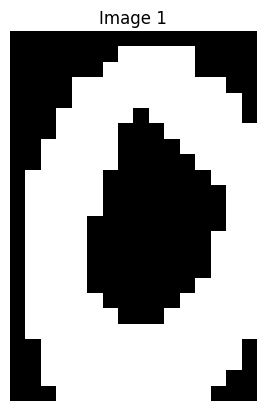

Displaying image 2/10


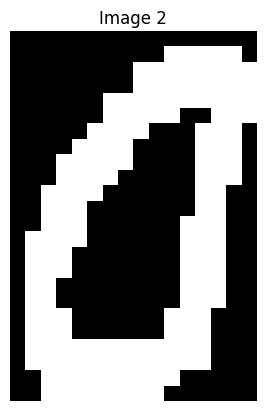

Displaying image 3/10


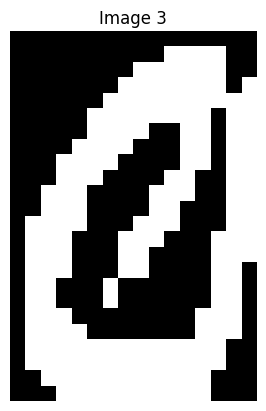

Displaying image 4/10


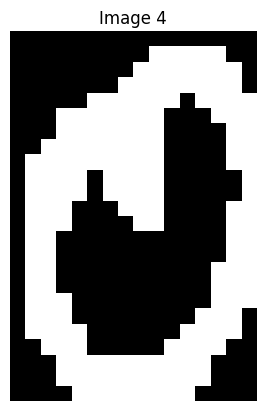

Displaying image 5/10


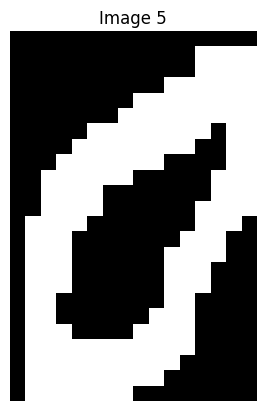

Displaying image 6/10


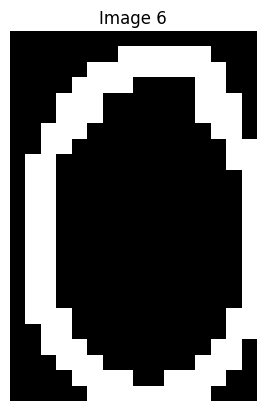

Displaying image 7/10


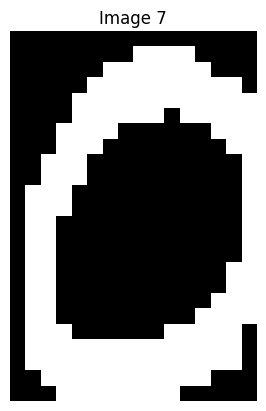

Displaying image 8/10


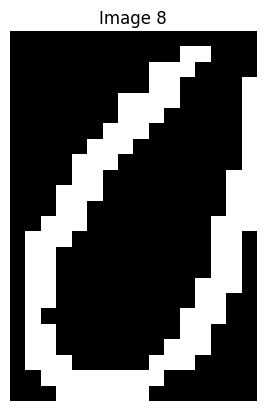

Displaying image 9/10


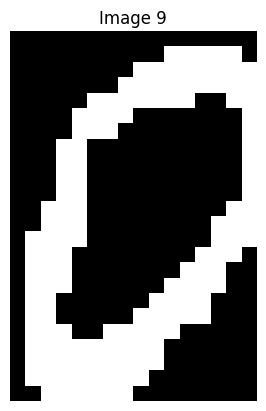

Displaying image 10/10


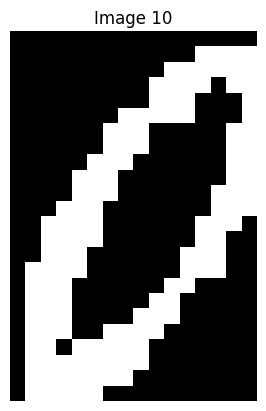

m00 is 214.0

Moments for m00 is [214.0]
m01 is 2759.0

Moments for m01 is [2759.0]
m10 is 1699.0

Moments for m10 is [1699.0]
m11 is 21463.0

Moments for m11 is [21463.0]
m00 is 167.0

Moments for m00 is [214.0, 167.0]
m01 is 2056.0

Moments for m01 is [2759.0, 2056.0]
m10 is 1336.0

Moments for m10 is [1699.0, 1336.0]
m11 is 14440.0

Moments for m11 is [21463.0, 14440.0]
m00 is 187.0

Moments for m00 is [214.0, 167.0, 187.0]
m01 is 2371.0

Moments for m01 is [2759.0, 2056.0, 2371.0]
m10 is 1554.0

Moments for m10 is [1699.0, 1336.0, 1554.0]
m11 is 18152.0

Moments for m11 is [21463.0, 14440.0, 18152.0]
m00 is 176.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0]
m01 is 2067.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0]
m10 is 1410.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0]
m11 is 15854.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0]
m00 is 169.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0]
m01 is 2074.0

Moments for m01 is [2759.0, 2056.0, 

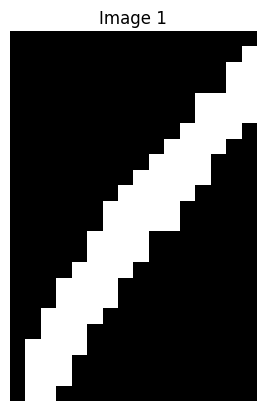

Displaying image 2/10


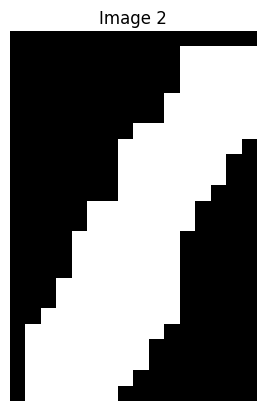

Displaying image 3/10


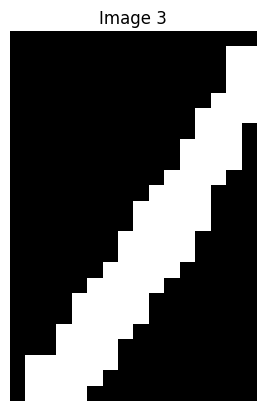

Displaying image 4/10


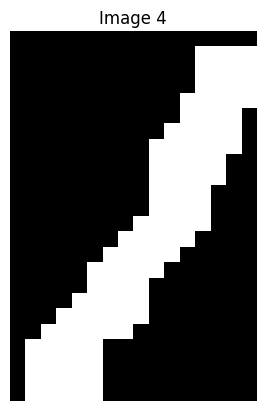

Displaying image 5/10


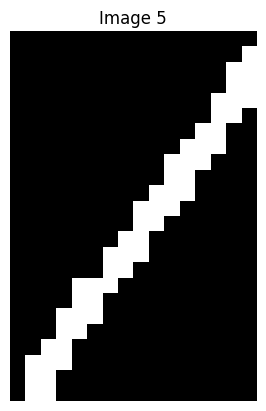

Displaying image 6/10


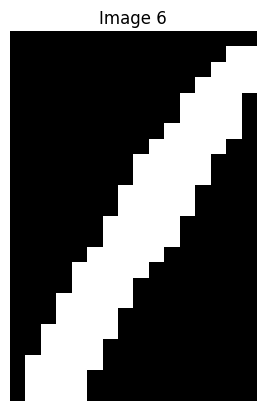

Displaying image 7/10


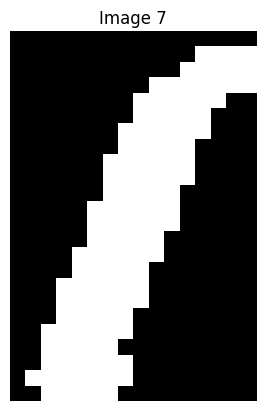

Displaying image 8/10


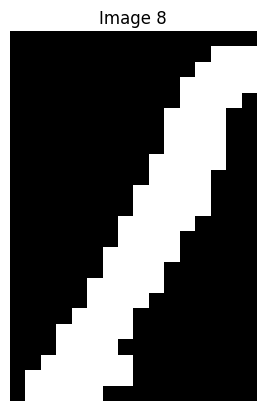

Displaying image 9/10


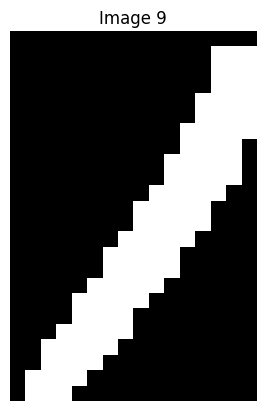

Displaying image 10/10


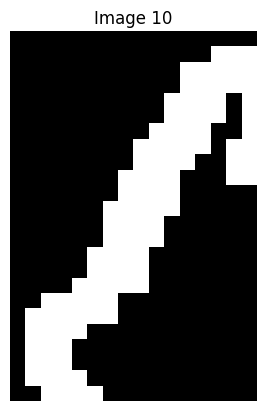

m00 is 84.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0]
m01 is 1025.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0]
m10 is 652.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0]
m11 is 6000.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0]
m00 is 161.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0]
m01 is 2039.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0, 2039.0]
m10 is 1301.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0, 1301.0]
m11 is 13429.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0, 13429.0]
m

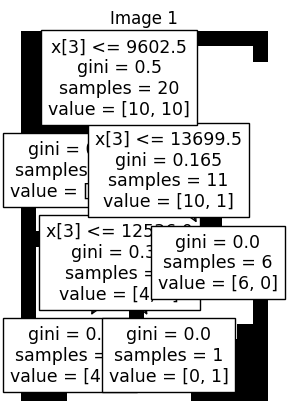

Displaying image 2/10


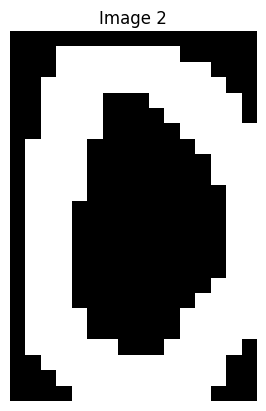

Displaying image 3/10


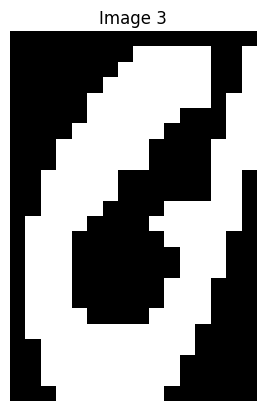

Displaying image 4/10


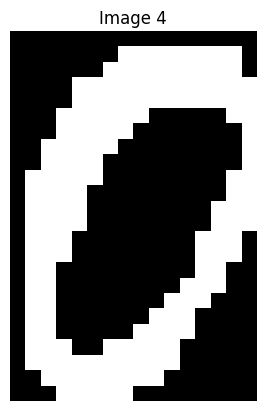

Displaying image 5/10


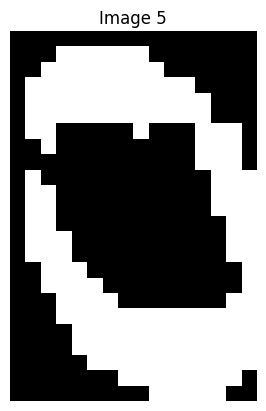

Displaying image 6/10


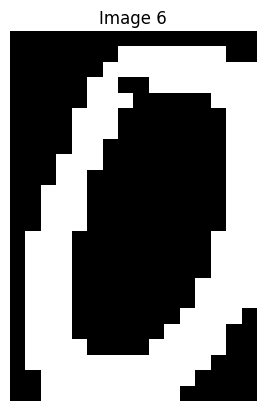

Displaying image 7/10


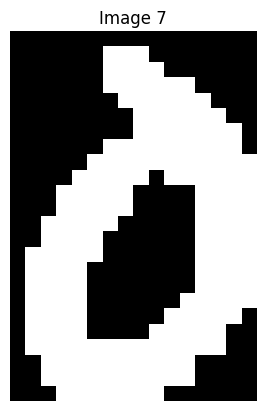

Displaying image 8/10


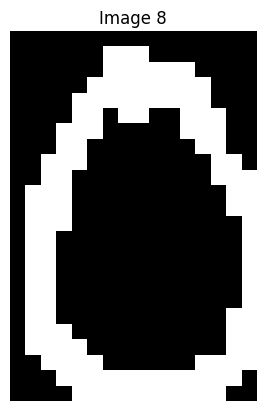

Displaying image 9/10


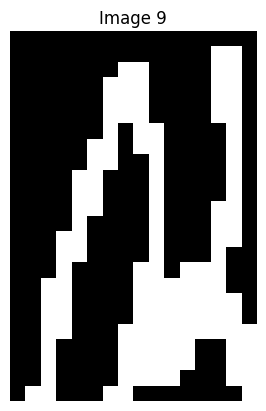

Displaying image 10/10


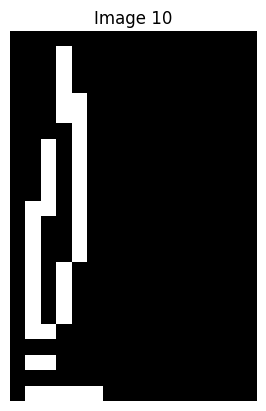

 Test vals 
Predicted classes for class 0 test patterns: [0 0 0 0 0 0 0 0 0 1]
Displaying image 1/10


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


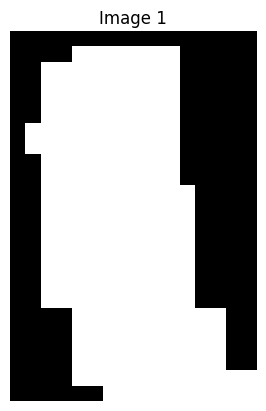

Displaying image 2/10


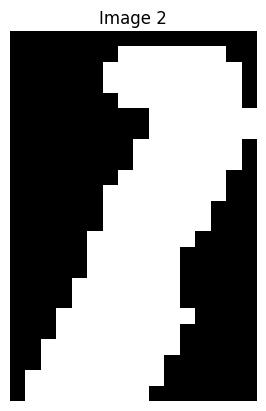

Displaying image 3/10


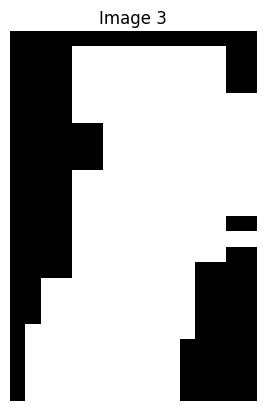

Displaying image 4/10


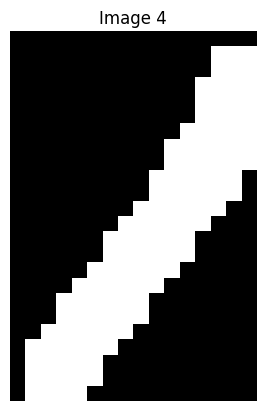

Displaying image 5/10


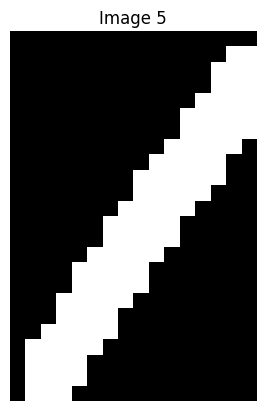

Displaying image 6/10


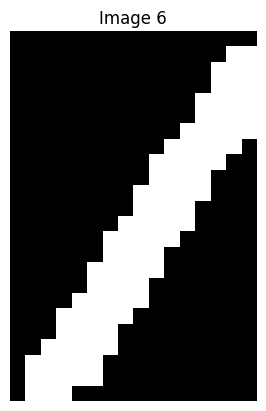

Displaying image 7/10


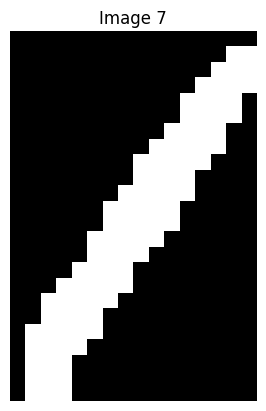

Displaying image 8/10


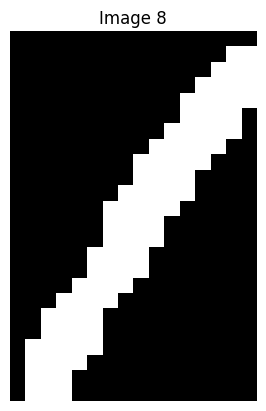

Displaying image 9/10


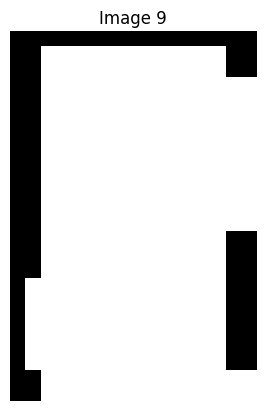

Displaying image 10/10


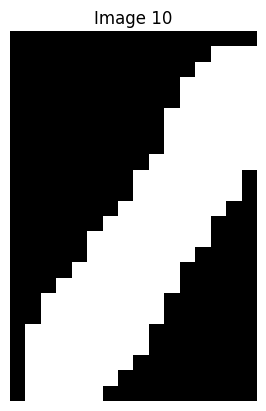

 Test vals 
Predicted classes for class 1 test patterns: [0 0 0 0 1 1 1 1 0 1]


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [14]:
def two_class_test():
    """
    Train and test the classifier for a two-class problem ("0" and "1").
    """
    # Train the classifier
    test_tree = DecisionTreeClassifier()
    print("Training the classifier for classes 0 and 1...")
    test_tree = train_classifier(test_tree, 2, 10)  # Two classes, 10 training examples each

    # Test the classifier
    print("\nTesting the classifier...")
    test_features = test_images(0, 10)  # Test 5 examples from class 0
    predictions = test_tree.predict(test_features)
    print(f"Predicted classes for class 0 test patterns: {predictions}")

    test_features = test_images(1, 10)  # Test 5 examples from class 1
    predictions = test_tree.predict(test_features)
    print(f"Predicted classes for class 1 test patterns: {predictions}")

# Run the test
two_class_test()


### Task 3: sett the image from uncomment statements

Training the classifier with debugging...
['m00', 'm01', 'm10', 'm11']
Displaying image 1/10


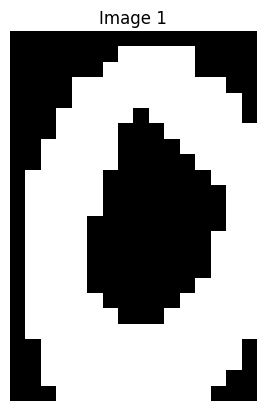

Displaying image 2/10


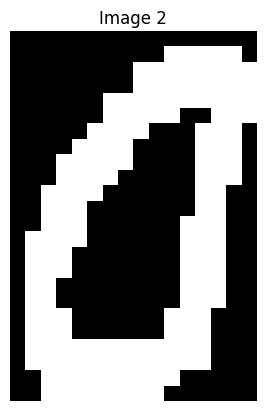

Displaying image 3/10


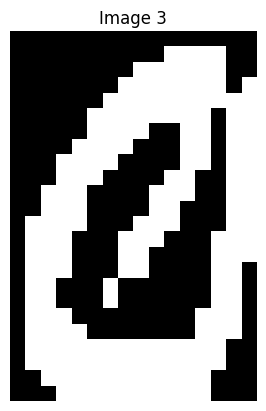

Displaying image 4/10


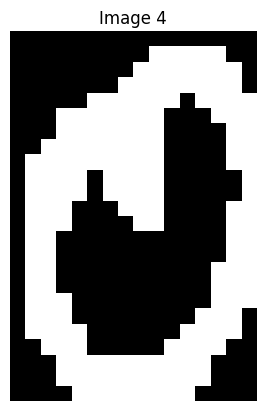

Displaying image 5/10


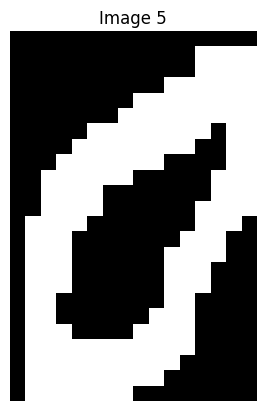

Displaying image 6/10


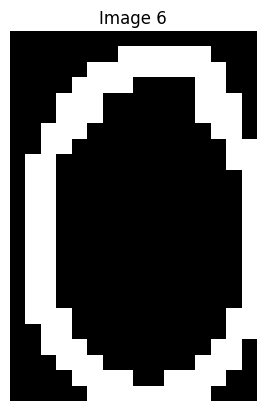

Displaying image 7/10


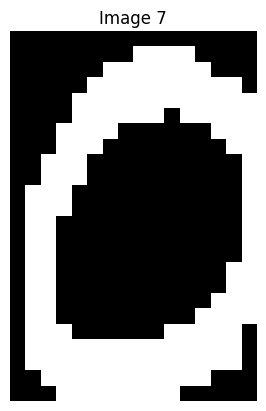

Displaying image 8/10


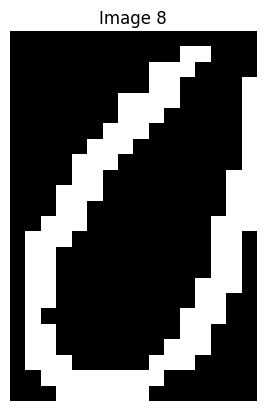

Displaying image 9/10


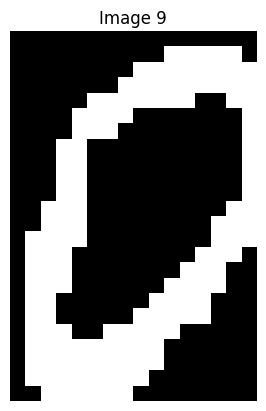

Displaying image 10/10


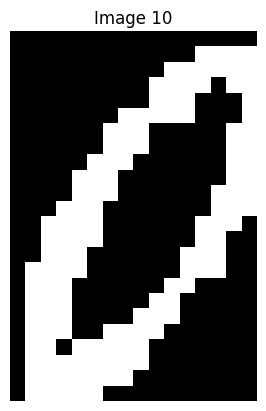

m00 is 214.0

Moments for m00 is [214.0]
m01 is 2759.0

Moments for m01 is [2759.0]
m10 is 1699.0

Moments for m10 is [1699.0]
m11 is 21463.0

Moments for m11 is [21463.0]
m00 is 167.0

Moments for m00 is [214.0, 167.0]
m01 is 2056.0

Moments for m01 is [2759.0, 2056.0]
m10 is 1336.0

Moments for m10 is [1699.0, 1336.0]
m11 is 14440.0

Moments for m11 is [21463.0, 14440.0]
m00 is 187.0

Moments for m00 is [214.0, 167.0, 187.0]
m01 is 2371.0

Moments for m01 is [2759.0, 2056.0, 2371.0]
m10 is 1554.0

Moments for m10 is [1699.0, 1336.0, 1554.0]
m11 is 18152.0

Moments for m11 is [21463.0, 14440.0, 18152.0]
m00 is 176.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0]
m01 is 2067.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0]
m10 is 1410.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0]
m11 is 15854.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0]
m00 is 169.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0]
m01 is 2074.0

Moments for m01 is [2759.0, 2056.0, 

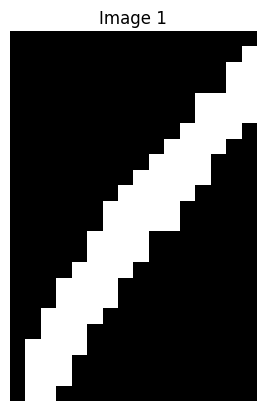

Displaying image 2/10


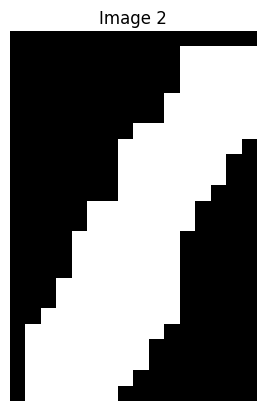

Displaying image 3/10


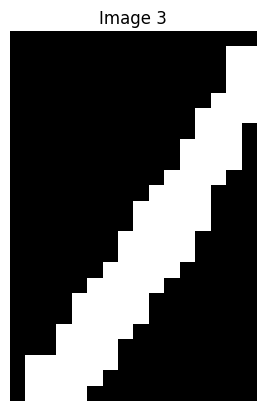

Displaying image 4/10


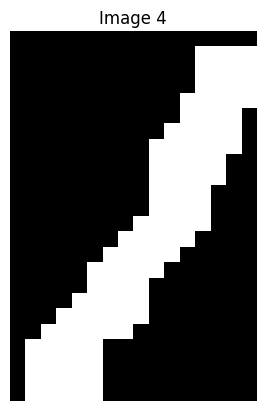

Displaying image 5/10


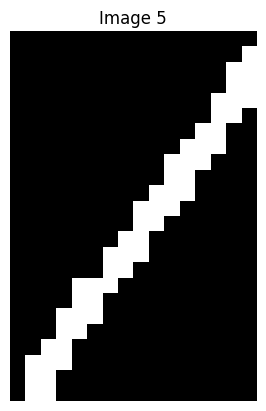

Displaying image 6/10


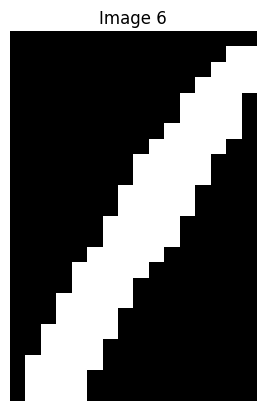

Displaying image 7/10


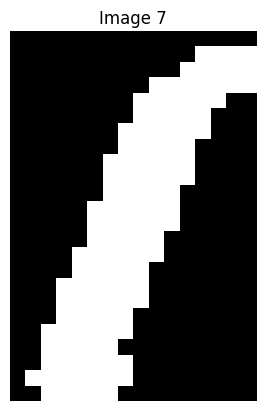

Displaying image 8/10


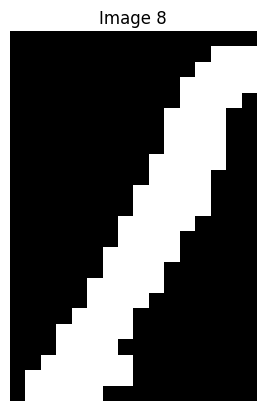

Displaying image 9/10


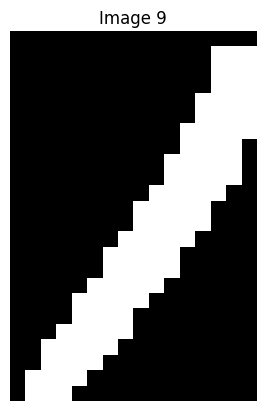

Displaying image 10/10


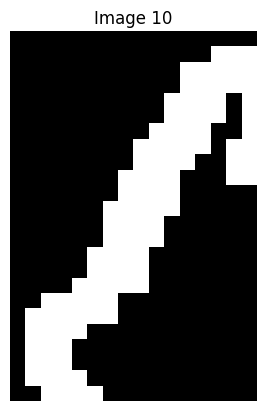

m00 is 84.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0]
m01 is 1025.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0]
m10 is 652.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0]
m11 is 6000.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0]
m00 is 161.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0]
m01 is 2039.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0, 2039.0]
m10 is 1301.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0, 1301.0]
m11 is 13429.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0, 13429.0]
m

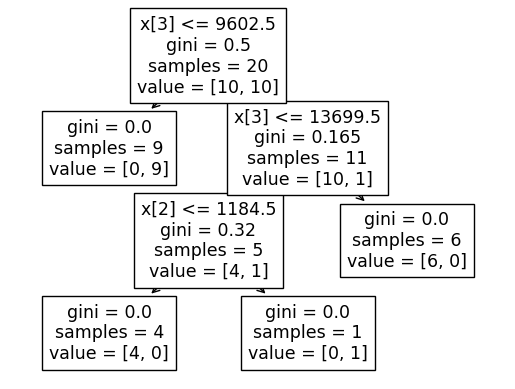

In [15]:
def debug_training():
    """
    Debug the training process by visualizing training data and the decision tree.
    """
    test_tree = DecisionTreeClassifier()
    print("Training the classifier with debugging...")
    test_tree = train_classifier(test_tree, 2, 10)  # Two classes, 10 training examples each

    # Visualize the decision tree
    print("\nVisualizing the decision tree...")
    tree.plot_tree(test_tree)
    plt.show()

# Run the debugging function
debug_training()


### Task 4 trying to predict 5 classes with 10 training examples

Training the classifier for 5 classes...
['m00', 'm01', 'm10', 'm11']
Displaying image 1/10


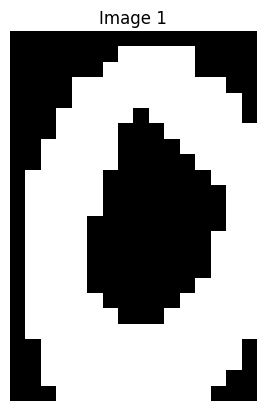

Displaying image 2/10


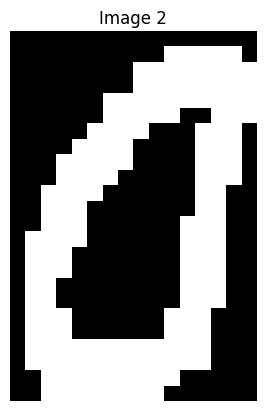

Displaying image 3/10


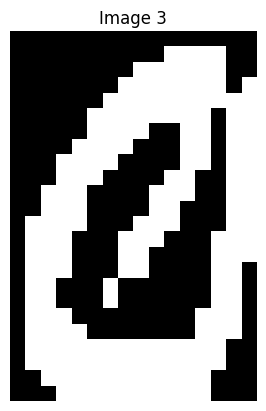

Displaying image 4/10


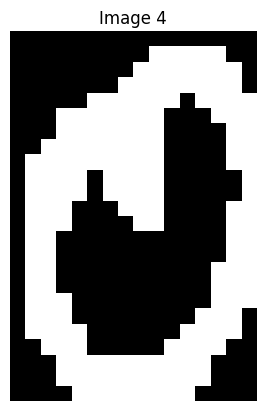

Displaying image 5/10


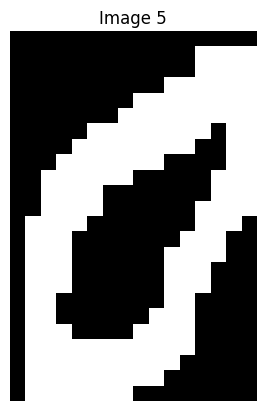

Displaying image 6/10


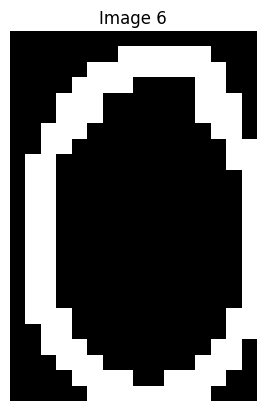

Displaying image 7/10


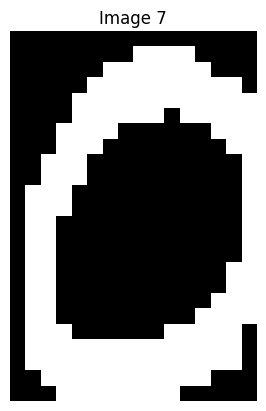

Displaying image 8/10


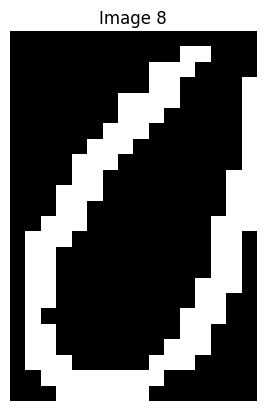

Displaying image 9/10


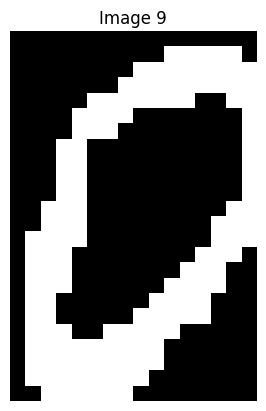

Displaying image 10/10


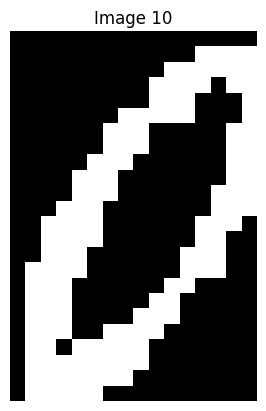

m00 is 214.0

Moments for m00 is [214.0]
m01 is 2759.0

Moments for m01 is [2759.0]
m10 is 1699.0

Moments for m10 is [1699.0]
m11 is 21463.0

Moments for m11 is [21463.0]
m00 is 167.0

Moments for m00 is [214.0, 167.0]
m01 is 2056.0

Moments for m01 is [2759.0, 2056.0]
m10 is 1336.0

Moments for m10 is [1699.0, 1336.0]
m11 is 14440.0

Moments for m11 is [21463.0, 14440.0]
m00 is 187.0

Moments for m00 is [214.0, 167.0, 187.0]
m01 is 2371.0

Moments for m01 is [2759.0, 2056.0, 2371.0]
m10 is 1554.0

Moments for m10 is [1699.0, 1336.0, 1554.0]
m11 is 18152.0

Moments for m11 is [21463.0, 14440.0, 18152.0]
m00 is 176.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0]
m01 is 2067.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0]
m10 is 1410.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0]
m11 is 15854.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0]
m00 is 169.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0]
m01 is 2074.0

Moments for m01 is [2759.0, 2056.0, 

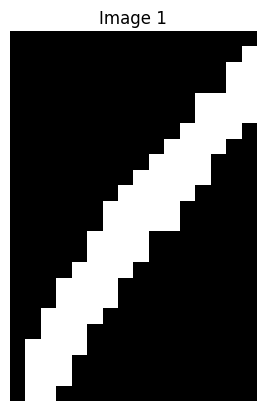

Displaying image 2/10


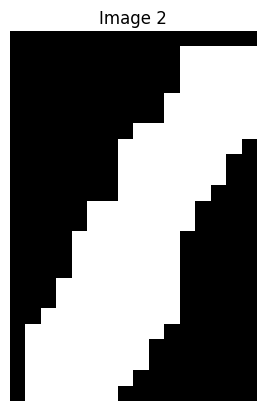

Displaying image 3/10


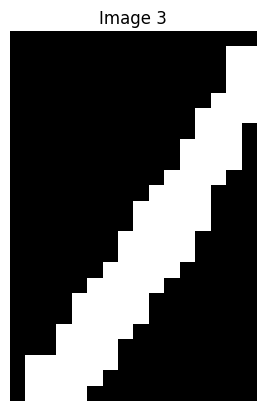

Displaying image 4/10


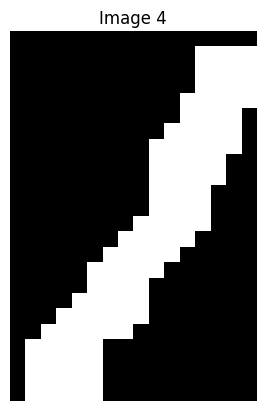

Displaying image 5/10


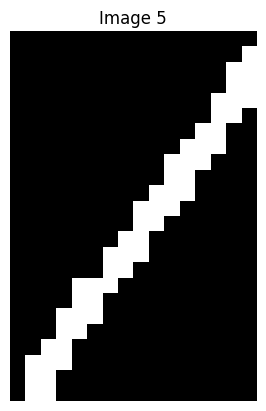

Displaying image 6/10


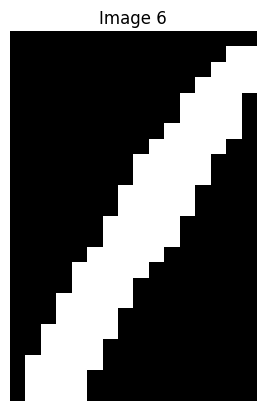

Displaying image 7/10


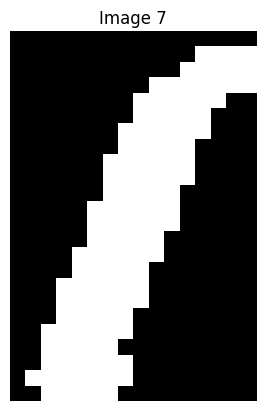

Displaying image 8/10


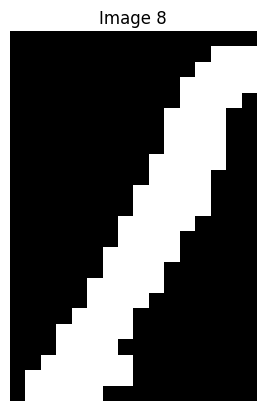

Displaying image 9/10


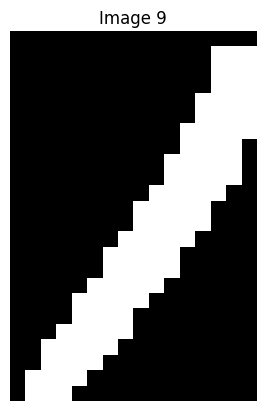

Displaying image 10/10


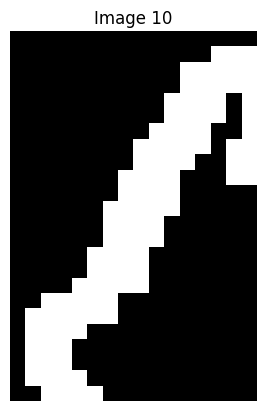

m00 is 84.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0]
m01 is 1025.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0]
m10 is 652.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0]
m11 is 6000.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0]
m00 is 161.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0]
m01 is 2039.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0, 2039.0]
m10 is 1301.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0, 1301.0]
m11 is 13429.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0, 13429.0]
m

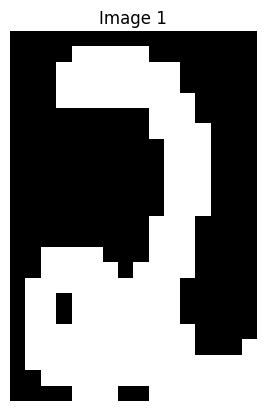

Displaying image 2/10


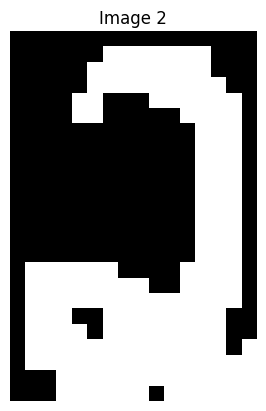

Displaying image 3/10


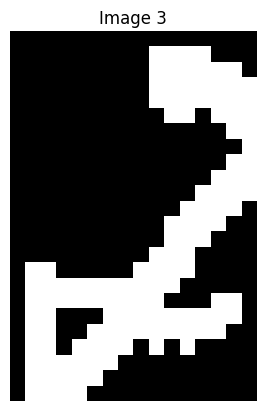

Displaying image 4/10


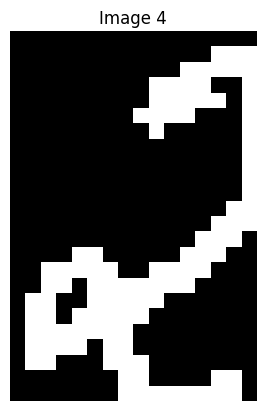

Displaying image 5/10


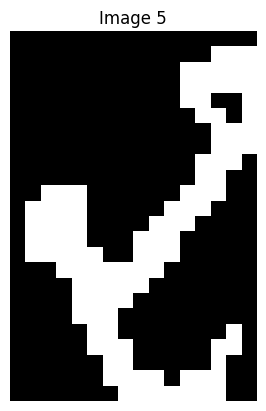

Displaying image 6/10


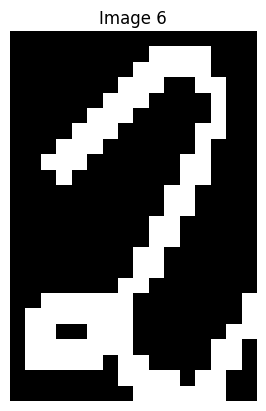

Displaying image 7/10


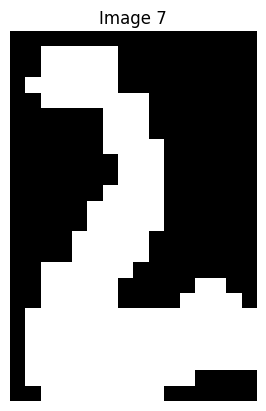

Displaying image 8/10


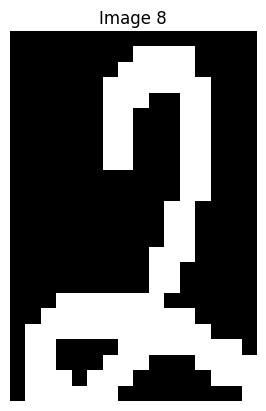

Displaying image 9/10


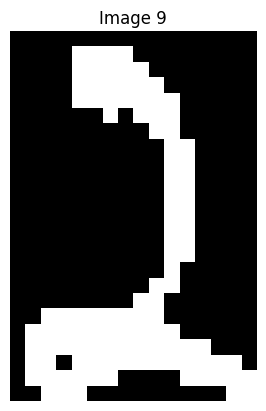

Displaying image 10/10


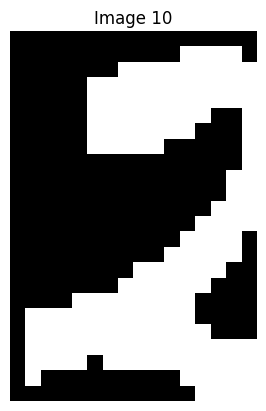

m00 is 164.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0, 96.0, 111.0, 54.0, 102.0, 129.0, 105.0, 101.0, 106.0, 164.0]
m01 is 2340.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0, 2039.0, 1281.0, 1376.0, 660.0, 1262.0, 1566.0, 1327.0, 1245.0, 1217.0, 2340.0]
m10 is 1240.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0, 1301.0, 824.0, 946.0, 440.0, 809.0, 967.0, 891.0, 911.0, 863.0, 1240.0]
m11 is 17654.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0, 13429.0, 8841.0, 9087.0, 3906.0, 7731.0, 9443.0, 8994.0, 8936.0, 7374.0, 17654.0]
m00 is 178.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0, 96.0, 111.0, 54.0, 102.0, 129.0, 105.0, 101.0, 106.0, 164.0, 178.0]
m01 is 2545.0

Moments for m0

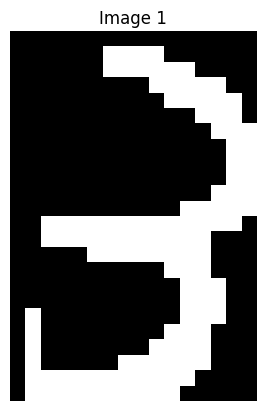

Displaying image 2/10


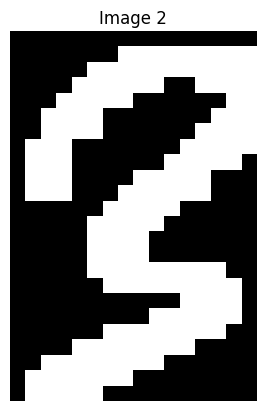

Displaying image 3/10


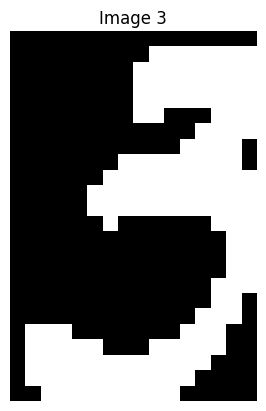

Displaying image 4/10


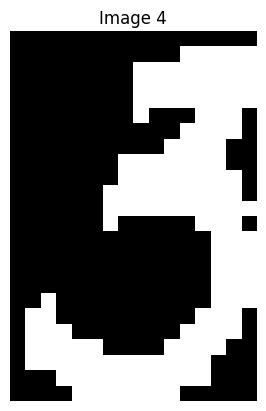

Displaying image 5/10


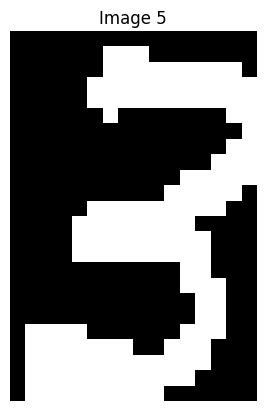

Displaying image 6/10


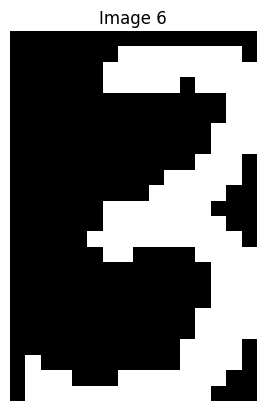

Displaying image 7/10


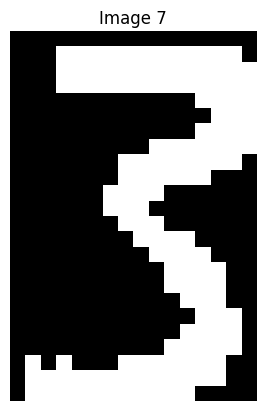

Displaying image 8/10


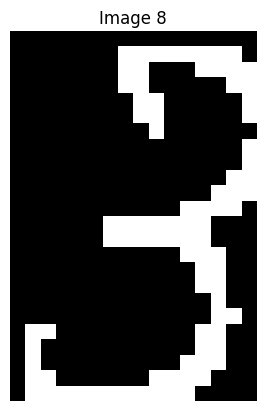

Displaying image 9/10


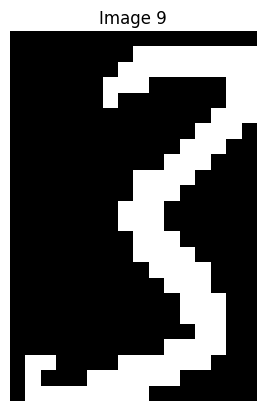

Displaying image 10/10


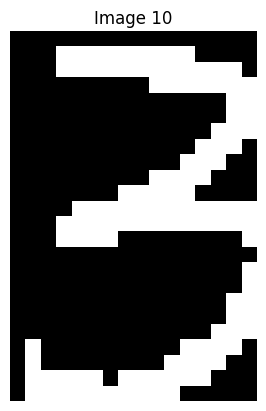

m00 is 122.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0, 96.0, 111.0, 54.0, 102.0, 129.0, 105.0, 101.0, 106.0, 164.0, 178.0, 127.0, 105.0, 109.0, 105.0, 164.0, 118.0, 108.0, 161.0, 122.0]
m01 is 1639.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0, 2039.0, 1281.0, 1376.0, 660.0, 1262.0, 1566.0, 1327.0, 1245.0, 1217.0, 2340.0, 2545.0, 1697.0, 1444.0, 1402.0, 1407.0, 2414.0, 1648.0, 1545.0, 2049.0, 1639.0]
m10 is 1118.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0, 1301.0, 824.0, 946.0, 440.0, 809.0, 967.0, 891.0, 911.0, 863.0, 1240.0, 1581.0, 1106.0, 921.0, 946.0, 826.0, 1108.0, 963.0, 809.0, 1531.0, 1118.0]
m11 is 13806.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0, 13429.0, 8841.0, 9087.0, 3906.0, 7731.0, 9443.0, 8994.0, 8936.0, 7374.0

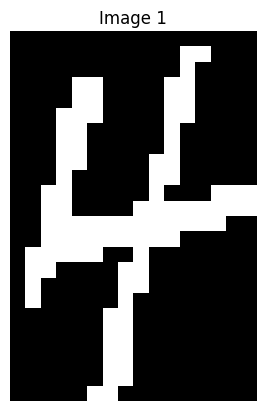

Displaying image 2/10


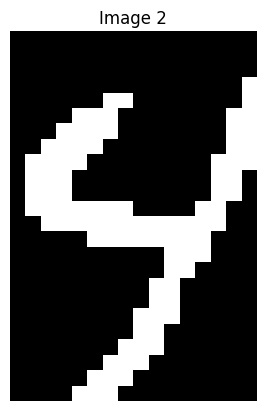

Displaying image 3/10


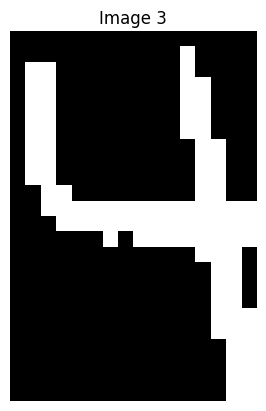

Displaying image 4/10


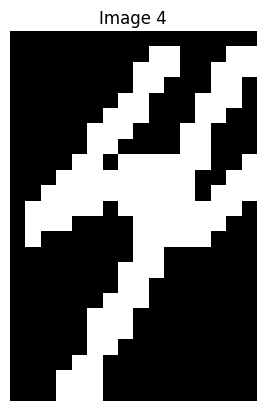

Displaying image 5/10


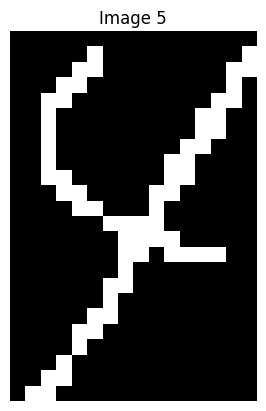

Displaying image 6/10


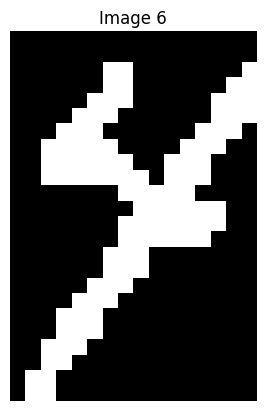

Displaying image 7/10


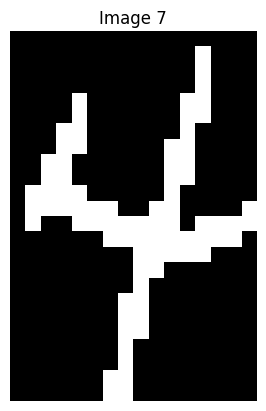

Displaying image 8/10


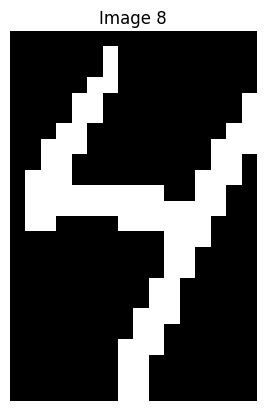

Displaying image 9/10


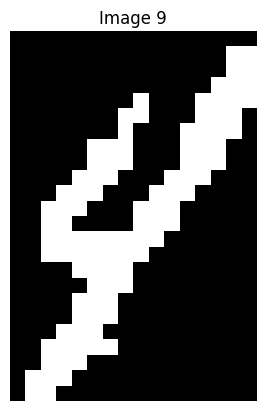

Displaying image 10/10


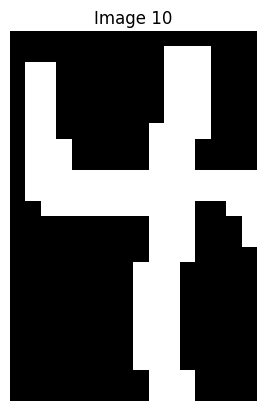

m00 is 93.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0, 161.0, 96.0, 111.0, 54.0, 102.0, 129.0, 105.0, 101.0, 106.0, 164.0, 178.0, 127.0, 105.0, 109.0, 105.0, 164.0, 118.0, 108.0, 161.0, 122.0, 167.0, 150.0, 145.0, 146.0, 129.0, 144.0, 88.0, 99.0, 120.0, 93.0]
m01 is 1058.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0, 2039.0, 1281.0, 1376.0, 660.0, 1262.0, 1566.0, 1327.0, 1245.0, 1217.0, 2340.0, 2545.0, 1697.0, 1444.0, 1402.0, 1407.0, 2414.0, 1648.0, 1545.0, 2049.0, 1639.0, 1881.0, 1824.0, 1803.0, 1872.0, 1591.0, 1649.0, 1109.0, 1198.0, 1409.0, 1058.0]
m10 is 647.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0, 1301.0, 824.0, 946.0, 440.0, 809.0, 967.0, 891.0, 911.0, 863.0, 1240.0, 1581.0, 1106.0, 921.0, 946.0, 826.0, 1108.0, 963.0, 809.0, 1531.0, 1118.0, 1376.0, 1485.0, 1451.0, 1267.0, 1369.0, 1374.0, 875.0, 964

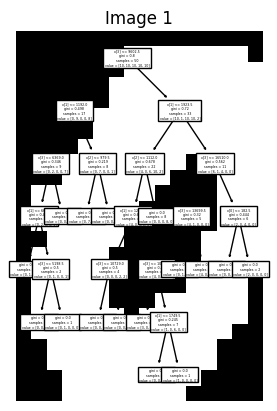

Displaying image 2/5


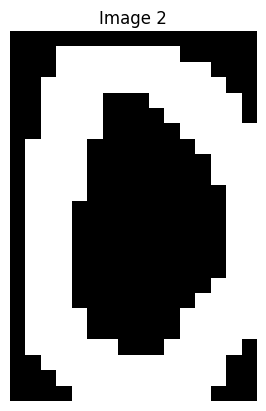

Displaying image 3/5


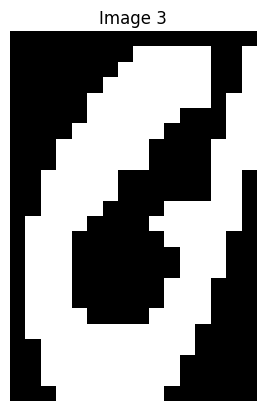

Displaying image 4/5


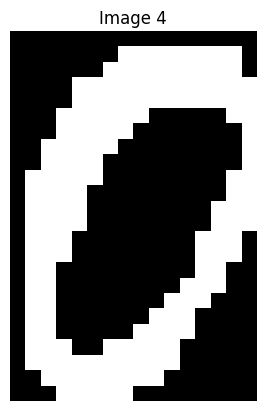

Displaying image 5/5


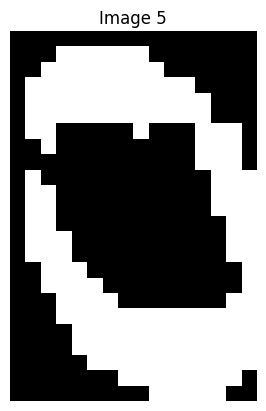

 Test vals 
Predicted classes for class 0 test patterns: [0 0 0 3 2]
Displaying image 1/5


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


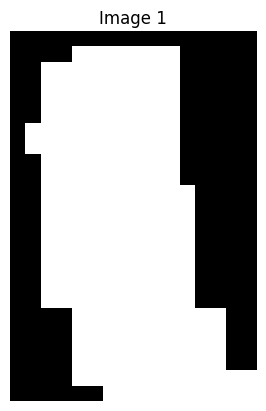

Displaying image 2/5


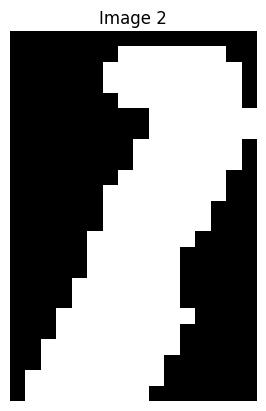

Displaying image 3/5


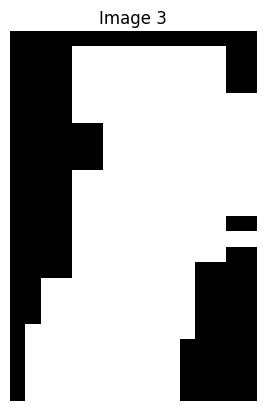

Displaying image 4/5


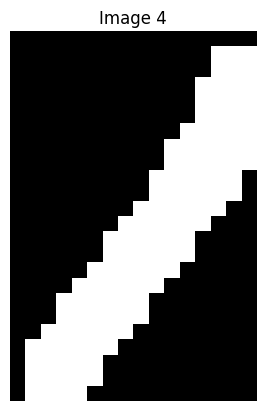

Displaying image 5/5


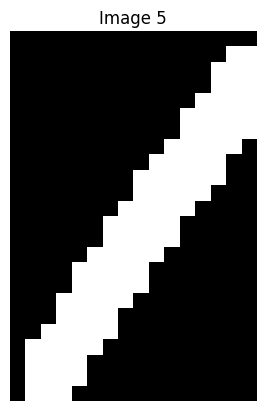

 Test vals 
Predicted classes for class 1 test patterns: [0 0 0 2 1]
Displaying image 1/5


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


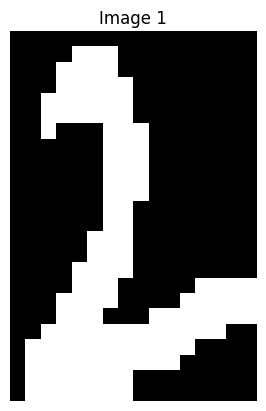

Displaying image 2/5


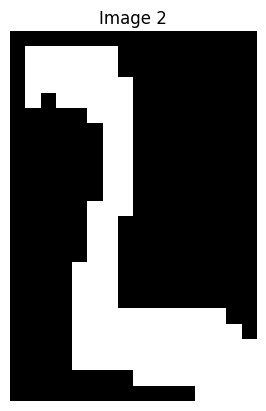

Displaying image 3/5


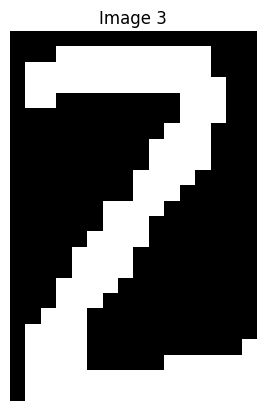

Displaying image 4/5


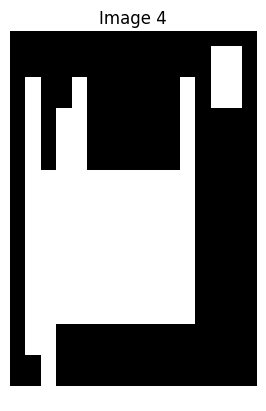

Displaying image 5/5


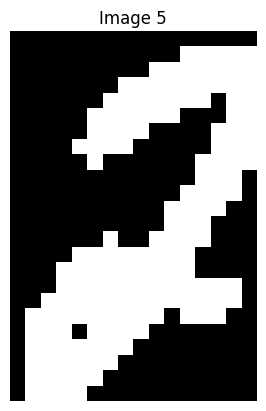

 Test vals 
Predicted classes for class 2 test patterns: [0 2 2 1 0]
Displaying image 1/5


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


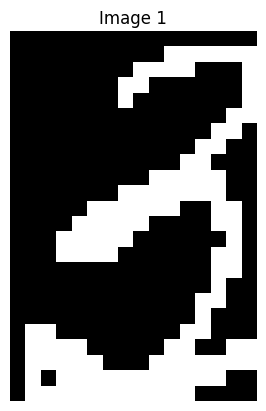

Displaying image 2/5


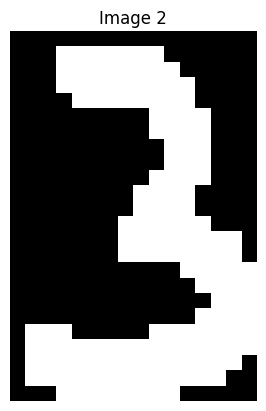

Displaying image 3/5


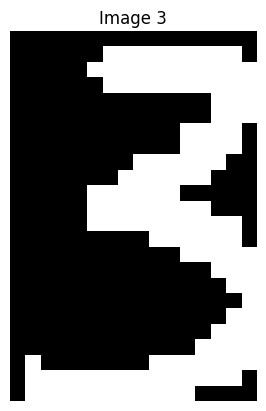

Displaying image 4/5


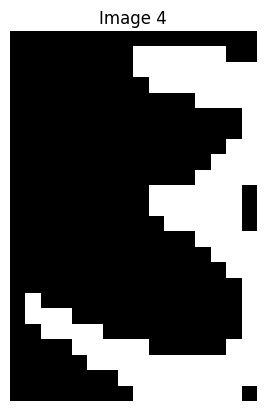

Displaying image 5/5


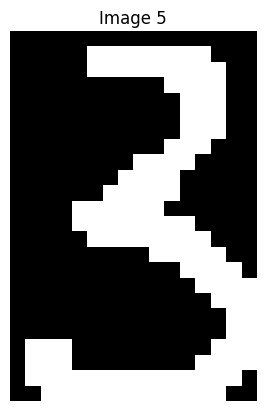

 Test vals 
Predicted classes for class 3 test patterns: [2 2 3 3 3]
Displaying image 1/5


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


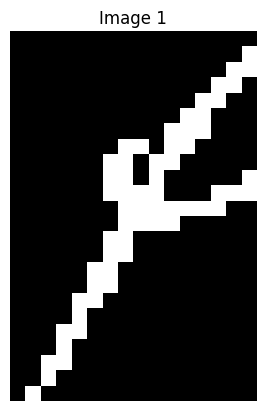

Displaying image 2/5


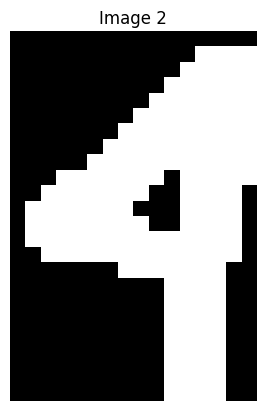

Displaying image 3/5


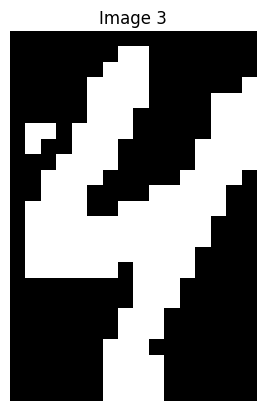

Displaying image 4/5


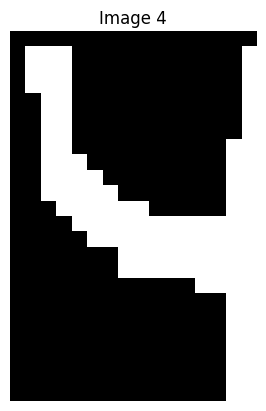

Displaying image 5/5


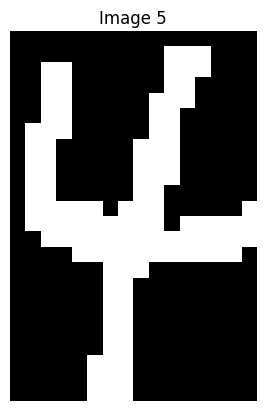

 Test vals 
Predicted classes for class 4 test patterns: [1 3 3 4 1]


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [16]:
def multi_class_test():
    """
    Train and test the classifier for multiple classes.
    """
    # Train the classifier for 5 classes
    test_tree = DecisionTreeClassifier()
    print("Training the classifier for 5 classes...")
    test_tree = train_classifier(test_tree, 5, 10)  # Five classes, 10 training examples each

    # Test the classifier
    print("\nTesting the classifier for 5 classes...")
    for class_id in range(5):
        test_features = test_images(class_id, 5)
        predictions = test_tree.predict(test_features)
        print(f"Predicted classes for class {class_id} test patterns: {predictions}")

# Run the multi-class test
multi_class_test()


### Task 5: try to increase the order of the moment by changing Constant values, PMAX and QMAX from global values

Training the classifier with higher-order moments...
['m00', 'm01', 'm02', 'm10', 'm11', 'm12', 'm20', 'm21', 'm22']
Displaying image 1/10


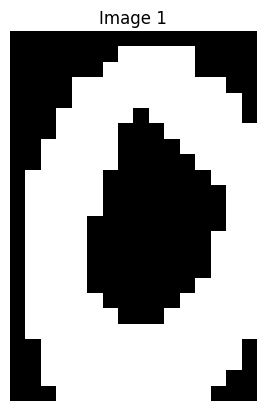

Displaying image 2/10


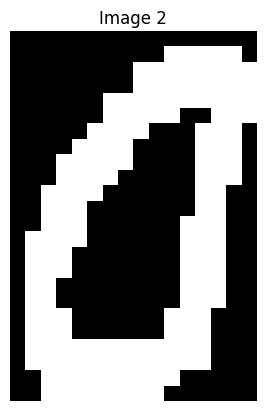

Displaying image 3/10


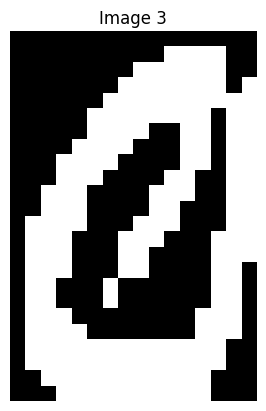

Displaying image 4/10


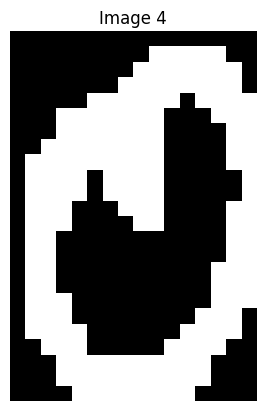

Displaying image 5/10


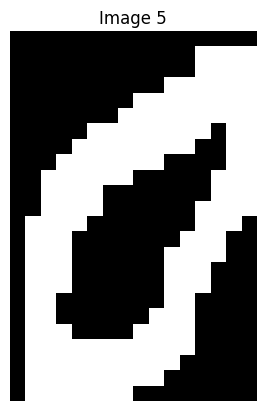

Displaying image 6/10


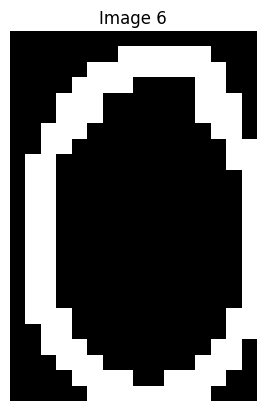

Displaying image 7/10


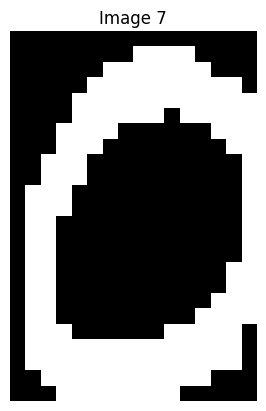

Displaying image 8/10


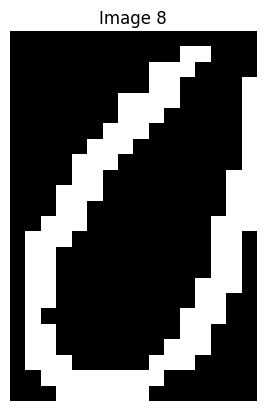

Displaying image 9/10


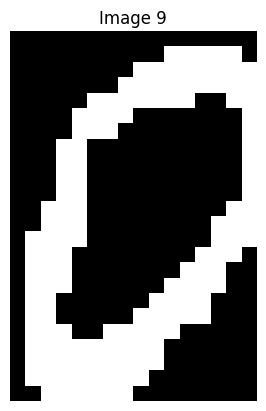

Displaying image 10/10


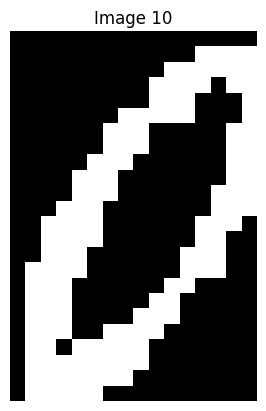

m00 is 214.0

Moments for m00 is [214.0]
m01 is 2759.0

Moments for m01 is [2759.0]
m02 is 45457.0

Moments for m02 is [45457.0]
m10 is 1699.0

Moments for m10 is [1699.0]
m11 is 21463.0

Moments for m11 is [21463.0]
m12 is 352461.0

Moments for m12 is [352461.0]
m20 is 17787.0

Moments for m20 is [17787.0]
m21 is 223659.0

Moments for m21 is [223659.0]
m22 is 3608841.0

Moments for m22 is [3608841.0]
m00 is 167.0

Moments for m00 is [214.0, 167.0]
m01 is 2056.0

Moments for m01 is [2759.0, 2056.0]
m02 is 33436.0

Moments for m02 is [45457.0, 33436.0]
m10 is 1336.0

Moments for m10 is [1699.0, 1336.0]
m11 is 14440.0

Moments for m11 is [21463.0, 14440.0]
m12 is 221958.0

Moments for m12 is [352461.0, 221958.0]
m20 is 13728.0

Moments for m20 is [17787.0, 13728.0]
m21 is 136772.0

Moments for m21 is [223659.0, 136772.0]
m22 is 1995494.0

Moments for m22 is [3608841.0, 1995494.0]
m00 is 187.0

Moments for m00 is [214.0, 167.0, 187.0]
m01 is 2371.0

Moments for m01 is [2759.0, 2056.0, 237

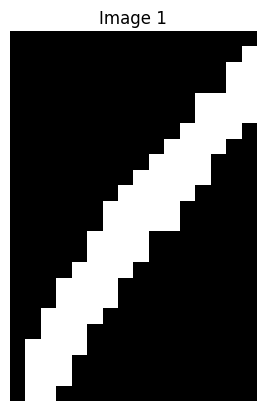

Displaying image 2/10


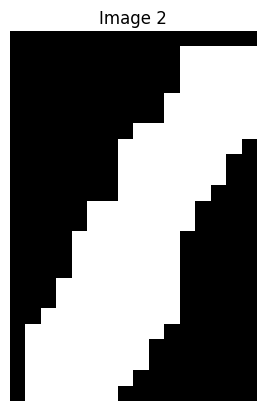

Displaying image 3/10


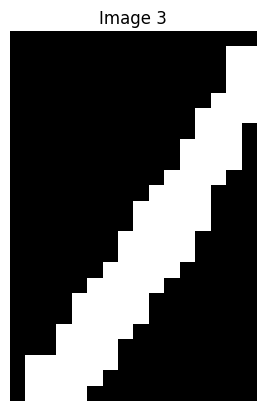

Displaying image 4/10


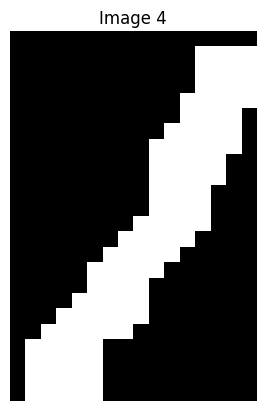

Displaying image 5/10


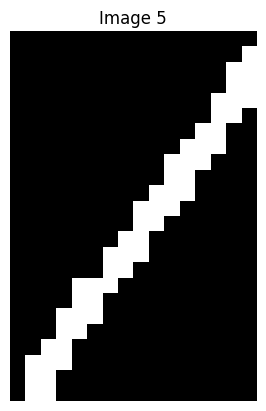

Displaying image 6/10


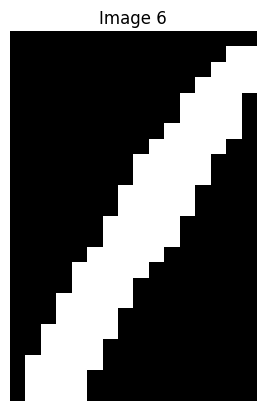

Displaying image 7/10


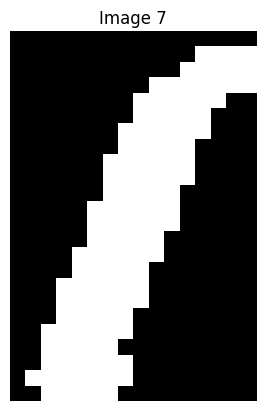

Displaying image 8/10


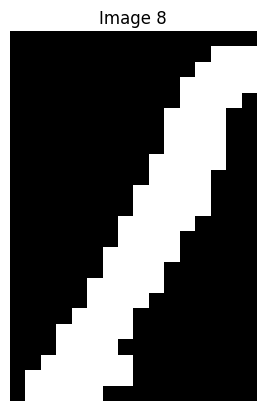

Displaying image 9/10


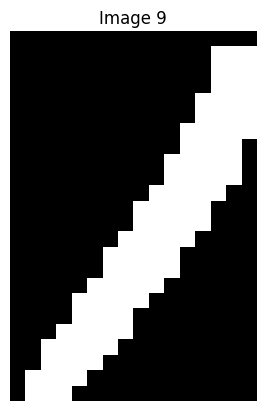

Displaying image 10/10


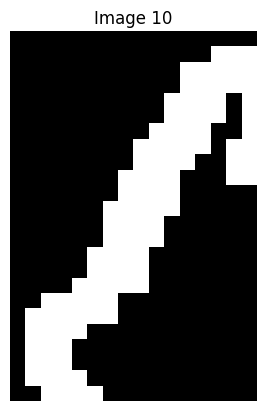

m00 is 84.0

Moments for m00 is [214.0, 167.0, 187.0, 176.0, 169.0, 109.0, 155.0, 103.0, 142.0, 134.0, 84.0]
m01 is 1025.0

Moments for m01 is [2759.0, 2056.0, 2371.0, 2067.0, 2074.0, 1289.0, 1966.0, 1360.0, 1802.0, 1690.0, 1025.0]
m02 is 15369.0

Moments for m02 is [45457.0, 33436.0, 38619.0, 32351.0, 32702.0, 21531.0, 33608.0, 22386.0, 29888.0, 27102.0, 15369.0]
m10 is 652.0

Moments for m10 is [1699.0, 1336.0, 1554.0, 1410.0, 1340.0, 843.0, 1230.0, 815.0, 1068.0, 1023.0, 652.0]
m11 is 6000.0

Moments for m11 is [21463.0, 14440.0, 18152.0, 15854.0, 13970.0, 9762.0, 14855.0, 9833.0, 11643.0, 10458.0, 6000.0]
m12 is 71670.0

Moments for m12 is [352461.0, 221958.0, 284984.0, 246806.0, 200570.0, 165752.0, 250793.0, 153373.0, 179799.0, 148050.0, 71670.0]
m20 is 6522.0

Moments for m20 is [17787.0, 13728.0, 16420.0, 14838.0, 14010.0, 9331.0, 13110.0, 8745.0, 10960.0, 10583.0, 6522.0]
m21 is 48618.0

Moments for m21 is [223659.0, 136772.0, 184294.0, 164206.0, 131122.0, 108680.0, 156097.0, 1

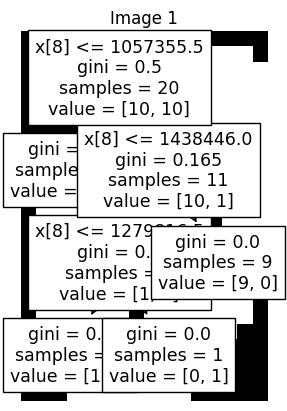

Displaying image 2/5


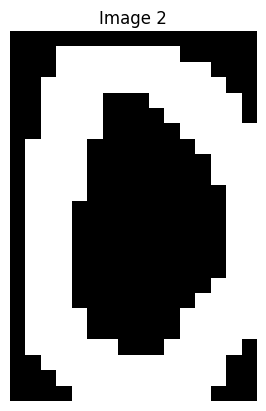

Displaying image 3/5


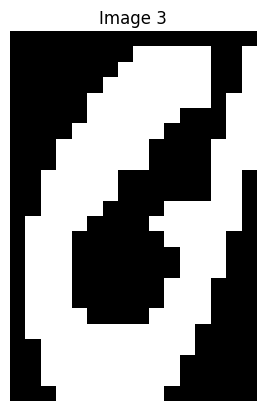

Displaying image 4/5


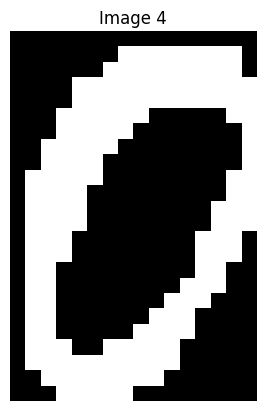

Displaying image 5/5


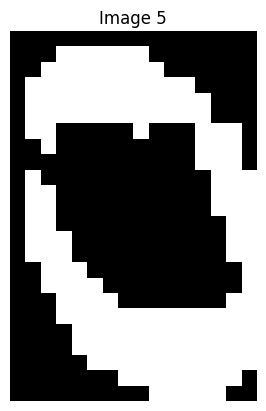

 Test vals 
Predicted classes for class 0 test patterns: [0 0 0 0 0]


/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [17]:
def high_order_moment_test():
    """
    Train and test the classifier with higher-order moments.
    """
    global PMAX, QMAX  # Temporarily modify these global constants
    PMAX, QMAX = 3, 3  # Increase to third-order moments

    # Train the classifier
    test_tree = DecisionTreeClassifier()
    print("Training the classifier with higher-order moments...")
    test_tree = train_classifier(test_tree, 2, 10)  # Two classes, 10 training examples each

    # Test the classifier
    print("\nTesting the classifier with higher-order moments...")
    test_features = test_images(0, 5)
    predictions = test_tree.predict(test_features)
    print(f"Predicted classes for class 0 test patterns: {predictions}")

    # Reset PMAX and QMAX if necessary
    PMAX, QMAX = 2, 2

# Run the test
high_order_moment_test()


## Appendix B

1. Observations

As the problem complexity increases:

- **More Features:** Higher-order moments (e.g., m20, m21) or normalized moments are necessary.
- **Training Data:** A larger and more representative training set is required.
- **Classifier Choice:** Decision Trees are transparent but may not scale well with complex data. Naïve Bayes, or even more advanced models like SVM or Neural Networks, could be explored for better results.

### Mornalised Moment

In [18]:
def normalized_moment(p, q, image):
    """
    Calculate the normalized central moment (p, q) for a binary image.

    Parameters:
    - p (int): Order of x in the moment calculation.
    - q (int): Order of y in the moment calculation.
    - image (numpy.ndarray): Binary image.

    Returns:
    - float: Normalized central moment.
    """
    # Calculate raw moments
    m00 = moment(0, 0, image)
    m10 = moment(1, 0, image)
    m01 = moment(0, 1, image)

    if m00 == 0:
        return 0  # Avoid division by zero

    # Calculate centroid
    x_bar = m10 / m00
    y_bar = m01 / m00

    # Central moment
    central_moment = 0
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y, x] == 1:
                central_moment += ((x - x_bar) ** p) * ((y - y_bar) ** q)

    # Normalize
    gamma = 1 + (p + q) / 2
    normalized_value = central_moment / (m00 ** gamma)

    return normalized_value


In [19]:
def gen_image_moments(pmax,qmax, image, results):

    for p in range(pmax):
        for q in range(qmax):

            m_name = "m" + str(p) + str (q) # generate the "name" of the moment to use to index the dictionary of moment values

            m = normalized_moment(p,q,image) # calculate the moment value m_pq

            print(m_name + " is "+ str(m) +"\n") # uncomment to see results as they are calculated

            results[m_name].append(m) # add the calculated moment to the appropriate entry in the dictionary --- can eliminate variable m if printing the value were not required

            print ("Moments for " + m_name + " is " + str(results[m_name])) # uncomment to see "running total" of moment values

    return(results)

def normalized_moment_tester():

    image = np.zeros((1,ROWS,COLS)) # space for one image

    feature_names = ["m" + str(p) + str (q) for p in range(2) for q in range(2)] # generate feature names for moments to order 2 (so we can see the outputs)

    panel_cols = generate_feature_dict(feature_names) # create empty dictionary

    read_images("train/br/", 1, 0,image) # read 1 image from the class 0 training file

    features = gen_image_moments(2,2,image[0],panel_cols) # calculate the moments up to order 2 for this image

    print( "FEATURES")
    print(features)

normalized_moment_tester()


m00 is 1.0

Moments for m00 is [1.0]
m01 is -1.4889269236129753e-15

Moments for m01 is [-1.4889269236129753e-15]
m10 is 6.241690609658053e-18

Moments for m10 is [6.241690609658053e-18]
m11 is -0.009638335144154119

Moments for m11 is [-0.009638335144154119]
FEATURES
{'m00': [1.0], 'm01': [-1.4889269236129753e-15], 'm10': [6.241690609658053e-18], 'm11': [-0.009638335144154119], 'class_id': []}


### Alternative Classifier: Naïve Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

def train_naive_bayes(num_classes, num_training_examples):
    """
    Train a Naïve Bayes classifier with moment features.

    Returns:
    - GaussianNB: Trained classifier.
    """
    images = np.zeros((MAX_EXAMPLES, ROWS, COLS))
    feature_names = [f"m{p}{q}" for p in range(PMAX) for q in range(QMAX)]
    feature_dict = generate_feature_dict(feature_names)

    for class_id in range(num_classes):
        images = read_images("train/br/", num_training_examples, class_id, images)
        feature_dict = gen_moment_features(class_id, num_training_examples, images, feature_dict)

    df = pd.DataFrame(feature_dict)
    features = df[feature_names]
    target = df["class_id"]

    model = GaussianNB()
    model.fit(features, target)
    return model


In [21]:
def test_naive_bayes(model, num_test_examples):
    """
    Test the Naïve Bayes model on test data.

    Parameters:
    - model: Trained Naïve Bayes model.
    - num_test_examples (int): Number of test examples per class.

    Returns:
    - None
    """
    for class_id in range(2):  # Assuming 2 classes
        # Generate test features for each class
        test_features = test_images(class_id, num_test_examples)

        # Predict classes and probabilities
        predictions = model.predict(test_features)
        probabilities = model.predict_proba(test_features)

        print(f"\nClass {class_id} Test Results:")
        for i, probs in enumerate(probabilities):
            print(f"Test {i + 1}: Prediction={predictions[i]}, Probabilities={probs}")



In [22]:
# Train a Naïve Bayes classifier
num_classes = 2  # Number of classes (e.g., "0" and "1")
num_training_examples = 10  # Number of training examples per class
nb_model = train_naive_bayes(num_classes, num_training_examples)

print("Naïve Bayes classifier trained successfully.")

m00 is 1.0

Moments for m00 is [1.0]
m01 is -1.4889269236129753e-15

Moments for m01 is [-1.4889269236129753e-15]
m10 is 6.241690609658053e-18

Moments for m10 is [6.241690609658053e-18]
m11 is -0.009638335144154119

Moments for m11 is [-0.009638335144154119]
m00 is 1.0

Moments for m00 is [1.0, 1.0]
m01 is -6.568381921532107e-16

Moments for m01 is [-1.4889269236129753e-15, -6.568381921532107e-16]
m10 is 0.0

Moments for m10 is [6.241690609658053e-18, 0.0]
m11 is -0.07199971314855315

Moments for m11 is [-0.009638335144154119, -0.07199971314855315]
m00 is 1.0

Moments for m00 is [1.0, 1.0, 1.0]
m01 is 6.196303148022578e-16

Moments for m01 is [-1.4889269236129753e-15, -6.568381921532107e-16, 6.196303148022578e-16]
m10 is -1.3059473002558796e-16

Moments for m10 is [6.241690609658053e-18, 0.0, -1.3059473002558796e-16]
m11 is -0.044364733745075643

Moments for m11 is [-0.009638335144154119, -0.07199971314855315, -0.044364733745075643]
m00 is 1.0

Moments for m00 is [1.0, 1.0, 1.0, 1.0]
